# Check and analysis gojek app sentimen

In [499]:
#dataFrame
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#NLTK
import nltk
from nltk.corpus import stopwords

#keras
from keras.models import Sequential


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#stemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Word2vec
import gensim

#helper
from collections import Counter
import emoji
import re
import time
import os
import logging
import pickle
import itertools


In [413]:
#read dataset
df = pd.read_csv("datagojekcopy.csv")
print(df.shape)

(20000, 4)


In [414]:
df.head(50)

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,sip... terima kasih 🙏
1,mimi cedar,5,2023-03-30 14:35:59,Bagaimana cara transfer sesama Gopay. Gopay sa...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,"Aman,dan cepat. Sesuai dengan ekspektasi.👍🏼👍🏼"
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,. aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,Cepet sampainya
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw
6,Irsya chanel,5,2023-03-30 14:15:20,bagus
7,Sunar tiee,2,2023-03-30 13:55:29,Kalou di perdalam susah dapetnya
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,saya top up gopay dengan nomer akun saya yang ...


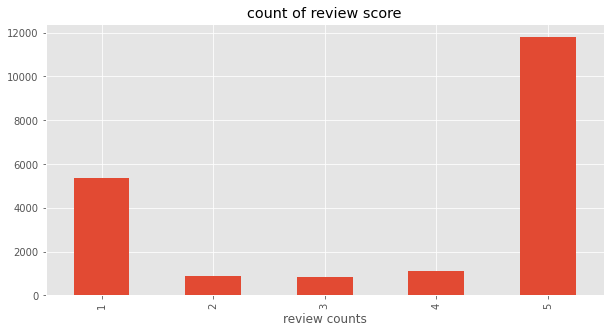

In [415]:
ax =df['score'].value_counts().sort_index().plot(
        kind = 'bar',
        title = 'count of review score',
        figsize = (10,5))
ax.set_xlabel("review counts")
plt.show()

# Preprocessing text
- menghilangkan emoji
- menghilangkan symbol
- stemmer
- word_stops

In [416]:
#Prepare preprocessing text
COBA = '\.'
TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'
stop_words = set(stopwords.words("indonesian"))
retain_words = {'baik','sekali'} #menghapus stopword dari kata baik sekali
stop_words = stop_words - retain_words
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [417]:
for word in sorted(stop_words):
    print(word)

ada
adalah
adanya
adapun
agak
agaknya
agar
akan
akankah
akhir
akhiri
akhirnya
aku
akulah
amat
amatlah
anda
andalah
antar
antara
antaranya
apa
apaan
apabila
apakah
apalagi
apatah
artinya
asal
asalkan
atas
atau
ataukah
ataupun
awal
awalnya
bagai
bagaikan
bagaimana
bagaimanakah
bagaimanapun
bagi
bagian
bahkan
bahwa
bahwasanya
bakal
bakalan
balik
banyak
bapak
baru
bawah
beberapa
begini
beginian
beginikah
beginilah
begitu
begitukah
begitulah
begitupun
bekerja
belakang
belakangan
belum
belumlah
benar
benarkah
benarlah
berada
berakhir
berakhirlah
berakhirnya
berapa
berapakah
berapalah
berapapun
berarti
berawal
berbagai
berdatangan
beri
berikan
berikut
berikutnya
berjumlah
berkali-kali
berkata
berkehendak
berkeinginan
berkenaan
berlainan
berlalu
berlangsung
berlebihan
bermacam
bermacam-macam
bermaksud
bermula
bersama
bersama-sama
bersiap
bersiap-siap
bertanya
bertanya-tanya
berturut
berturut-turut
bertutur
berujar
berupa
besar
betul
betulkah
biasa
biasanya
bila
bilakah
bisa
bisakah
boleh
boleh

In [418]:
# Remove emoji
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol & piktograf
                               u"\U0001F680-\U0001F6FF"  # transport & simbol peta
                               u"\U0001F1E0-\U0001F1FF"  # bendera (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub('',text)

In [419]:
text = df['content'].loc[0]
print(remove_emoji(text))

sip... terima kasih 


In [420]:
# remove all emoji
def remove_all(text):
    sentence = remove_emoji(text)
    return sentence
    

In [421]:
df.content = df.content.apply(lambda x:remove_all(x))

In [422]:
df.head(50)

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,sip... terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,Bagaimana cara transfer sesama Gopay. Gopay sa...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,"Aman,dan cepat. Sesuai dengan ekspektasi."
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,. aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,Cepet sampainya
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw
6,Irsya chanel,5,2023-03-30 14:15:20,bagus
7,Sunar tiee,2,2023-03-30 13:55:29,Kalou di perdalam susah dapetnya
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,saya top up gopay dengan nomer akun saya yang ...


In [423]:
#drop null content
for x in df.index:
    if df.loc[x,'content'] == "":
        df.drop(x, inplace = True)
df.shape

(19722, 4)

In [424]:
#menghilangkan symbol
def remove_symbol(text):
    text = re.sub(COBA,'',str(text).strip())
    return text

In [425]:
#menghilangkan symbol
def remove_symbol_clean(text):
    text = re.sub(TEXT_CLEANING_RE,' ',str(text).lower().strip())
    return text

In [426]:
text = "sip... terima kasih"
print(remove_symbol(text))

sip terima kasih


In [427]:
#stopwords
def stopWordsData(text, stem = False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

# Cleaning singkatan kata

In [428]:
#read_dataset singkatan (data didapat dari scrapping data)
df_singkatan_scrap = pd.read_csv("singkatan_1_kata.csv")
df_singkatan_scrap.head()

,Singkatan,Kata
0,7an,tujuan
1,@,di
2,ababil,abg labil
3,abis,habis
4,acc,accord


In [429]:
#pindahkan ke dictionary
singkatan_dict_scrap = dict(zip(df_singkatan_scrap['Singkatan'], df_singkatan_scrap['Kata']))
df_singkatan_scrap.shape

(1481, 2)

In [430]:
#Membuat function mengubah singkatan dari bahasa indonesia
singkatan = {
    #a
    "apaa": "apa",
    "apaaa": "apa",
    "apaaaa": "apa",
    #b
    "bsa": "bisa",
    "byk": "banyak",
    #c
    #d
    "dowload": "download",
    "da": "ada",
    "dll": "dan lain-lain",
    "d": "di",
    #e
    "elu": "kamu",
    #f
    #g
    "gbisa": "gak bisa",
    "gagu": "gak guna",
    "g": "gak",
    "gk": "gak",
    "gohek": "gojek",
    "goek": "gojek",
    #h
    #i
    #j
    #k
    "knp": "kenapa",
    #l
    "loding":"loading",
    "lg": "lagi",
    "li": "beli",
    "lu": "kamu",
    #m
    "mantaap" : "mantap",
    "mantapp": "mantap",
    "mantaf": "mantap",
    #n
    "n": "dan",
    #o
    #p
    "pedning": "pending",
    #q
    #r
    #s
    "sp": "siapa",
    "sdh": "sudah",
    "sngt": "sangat",
    #t
    "tq": "thank you",
    "tp": "tapi",
    "trs": "terus",
    "trims": "terima kasih",
    #u
    "u": "kamu",
    "udh": "udah",
    #v
    #w
    #x
    #y
    "yg": "yang",
    "sy": "saya",
    "y": "iya"
    #z
    
}

df_singkatan = pd.DataFrame(list(singkatan.items()),columns = ['singkatan','kata'])
singkatan_dict = dict(zip(df_singkatan['singkatan'], df_singkatan['kata']))

def changeAbbreviation_DF(text):
    words = text.split()
    new_words = [singkatan_dict[word] if word in singkatan_dict else word for word in words]
    return " ".join(new_words)

def changeAbbreviation_DF_scrap(text):
    words = text.split()
    new_words =[singkatan_dict_scrap[word] if word in singkatan_dict_scrap else word for word in words]
    return " ".join(new_words)

def changeAbbreviation(text):
    words = text.split()
    
    for i in range(len(words)):
        if words[i] in df_singkatan['singkatan']:
            words[i] = df_singkatan['kata',[words[i]]]
    return " ".join(words)

In [431]:
#remove symbol tandak titik .
df.content = df.content.apply(lambda x: remove_symbol(x))

In [432]:
#normalisasi mengubah singkatan
df.content = df.content.apply(lambda x: changeAbbreviation_DF(x))

In [433]:
text = df.loc[33,'content']
print(text)

pas di gunakan untuk pembayaran gak bisa di gunakan padahal udah gak bawa uang lagi dana ada di gopay menjengkelkan buang waktu malu maluin aja payah


In [434]:
text = df.loc[33,'content']
print(text)

pas di gunakan untuk pembayaran gak bisa di gunakan padahal udah gak bawa uang lagi dana ada di gopay menjengkelkan buang waktu malu maluin aja payah


In [435]:
text = df.loc[45,'content']
print(text)

Tiba" akun hrs upgrade ke gopplus padahal saya pengguna dr tahun 2016 dan smua transaksi berantakan


In [436]:
#normalisasi mengubah singkatan
df.content = df.content.apply(lambda x: changeAbbreviation_DF_scrap(x))

In [437]:
text = df.loc[45,'content']
print(text)

Tiba" akun harus              upgrade ke gopplus padahal saya pengguna dari              tahun 2016 dan semua              transaksi berantakan


In [438]:
#hapus symbol
df.content = df.content.apply(lambda x: remove_symbol_clean(x))

In [439]:
text = df.loc[45,'content']
print(text)

tiba akun harus upgrade ke gopplus padahal saya pengguna dari tahun 2016 dan semua transaksi berantakan


In [440]:
#Function Merger preprocessing_text

def preprocessing_text(text):
    content = text
    content = remove_symbol(content)
    content = changeAbbreviation_DF(content)
    content = stopWordsData(content)
    
    return content
    
    

## Buat new_df untuk Membuat similiar untuk proses normalisasi

In [441]:
new_df = df.reset_index(drop = True)
new_df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,bagaimana cara transfer sesama gopay gopay say...
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman dan cepat sesuai dengan ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi yang cukup membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya


In [442]:
new_df.content = new_df.content.apply(lambda x: preprocessing_text(x))

In [443]:
new_df.head()

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya


## Dibawah ini hanyalah sampel-sampel

In [444]:
sampleN = df['content'].loc[12]
sampleP = df['content'].loc[33]

In [445]:
print(sampleP) #with score 5
print("-------------")
print(sampleN) #with score 1

pas di gunakan untuk pembayaran tidak bisa di gunakan padahal sudah tidak bawa uang lagi dana ada di gopay menjengkelkan buang waktu malu maluin saja payah
-------------
tolong iya admin di training lagi supir goride nya saya sudah mengalami kekecewaan dua kali yang pertama supir tidak hati hati di jalan macet dia nyalip tapi tidak pakai perhitungan sampai kaki saya kebentur tiang telepon dan kenalpot motor orang lain di jalan dan yang kedua supir ngeyel padahal dia yang salah tapi tidak mau mengaku salah bahkan pergi tiba tiba saat saya sedang bicara


In [446]:
sampleN = new_df['content'].loc[12]
sampleP = new_df['content'].loc[33]

In [447]:
print(sampleP) #with score 5
print("-------------")
print(sampleN) #with score 1

pas pembayaran bawa uang dana gopay menjengkelkan buang malu maluin payah
-------------
tolong iya admin training supir goride nya mengalami kekecewaan kali supir hati hati jalan macet nyalip pakai perhitungan kaki kebentur tiang telepon kenalpot motor orang jalan supir ngeyel salah mengaku salah pergi bicara


## sentimen menggunakan Inset based lexicon
link https://github.com/fajri91/InSet

In [448]:
new_df.head(20)

,userName,score,at,content
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw
6,Irsya chanel,5,2023-03-30 14:15:20,bagus
7,Sunar tiee,2,2023-03-30 13:55:29,kalou perdalam susah dapetnya
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,top up gopay nomer akun salah kirim orang ya m...


In [449]:
#preprocessed_content
def preprocessed_content(text):
    words = text.split()
    return words

In [450]:
new_df['[preprocessed_content]'] = new_df['content'].apply(lambda x: preprocessed_content(x))

In [451]:
new_df.shape

(19722, 5)

In [452]:
#drop kembali karena melakukan process stopwords yang kata-katanya tidak diketahui
y = 0
for i in new_df.index:
    try:
        if new_df.loc[i, 'content'] == "":
            new_df.drop(i, inplace=True)
            y += 1
    except KeyError:
        continue
print(y)
new_df.shape

111


(19611, 5)

In [453]:
#mereset index kembali setelah di drop
new_df = new_df.reset_index(drop = True)

In [454]:
#read tsv
#negatif
df_negatif = pd.read_csv('negative.tsv', sep='\t')

In [455]:
df_positif = pd.read_csv('InSet-Master\positive.tsv',sep='\t')

In [456]:
#Merubah lexicon karena kalimat tersebut bersifat positif
#pada dataFrame Negatif
#aplikasi = 0,bagus = 0 ,membantu = 0 
df_negatif.loc[df_negatif['word'] == 'membantu','weight'] = 0
df_negatif.loc[df_negatif['word'] == 'aplikasi','weight'] = 0
df_negatif.loc[df_negatif['word'] == 'bagus','weight'] = 0


#ubah menjadi dictionary
sentiment_lexicon_positif = df_positif.set_index('word')['weight'].to_dict()
sentiment_lexicon_negatif = df_negatif.set_index('word')['weight'].to_dict()

In [457]:
#Function positif
def analyze_sentiment_positif(sentence):
    words = sentence.split()
    sentiment_score = 0
    #hasil = "netral"
    
    for word in words:
        sentiment_score += sentiment_lexicon_positif.get(word, 0)
        
    if sentiment_score > 0:
        return sentiment_score
    elif sentiment_score < 0:
        return sentiment_score
    else:
        return sentiment_score
        
def analyze_sentiment_negatif(sentence):
    words = sentence.split()
    sentiment_score = 0
    #hasil = "netral"
    
    for word in words:
        sentiment_score += sentiment_lexicon_negatif.get(word, 0)
        
    if sentiment_score > 0:
        return sentiment_score
    elif sentiment_score < 0:
        return sentiment_score
    else:
        return sentiment_score

In [458]:
new_df['lexicon_positif'] = 0
new_df['lexicon_negatif'] = 0

In [459]:
new_df.lexicon_positif = new_df.content.apply(lambda x: analyze_sentiment_positif(x))

In [460]:
new_df.lexicon_negatif = new_df.content.apply(lambda x: analyze_sentiment_negatif(x))

In [461]:
final = []
for x in new_df.index:
    hasil = 0
    hasil = new_df.loc[x,'lexicon_positif'] + new_df.loc[x,'lexicon_negatif']
    final.append(hasil)
print("finish")

finish


In [462]:
new_df['final_lexicon'] = final

In [463]:
new_df.head(50)

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[ok, terima, kasih]",8,-1,7
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[transfer, gopay, gopay, transfer, gopay]",0,0,0
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[aman, cepat, sesuai, ekspektasi]",6,-3,3
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[aplikasi, membantu]",4,0,4
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya,"[cepet, sampainya]",2,0,2
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw,[yihaw],0,0,0
6,Irsya chanel,5,2023-03-30 14:15:20,bagus,[bagus],2,0,2
7,Sunar tiee,2,2023-03-30 13:55:29,kalou perdalam susah dapetnya,"[kalou, perdalam, susah, dapetnya]",0,-3,-3
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali,"[baik, sekali]",3,-2,1
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,top up gopay nomer akun salah kirim orang ya m...,"[top, up, gopay, nomer, akun, salah, kirim, or...",11,-5,6


In [464]:
#change label if lexicon > 0 positive, lexicon < 0 negative, lexicon == 0 neutral
status_lexicon = []

for x in new_df.index:
    status = "neutral"
    if new_df.loc[x,'final_lexicon'] > 0:
        status = "positif"
        status_lexicon.append(status)
    elif new_df.loc[x,'final_lexicon'] < 0:
        status = "negatif"
        status_lexicon.append(status)
    else:
        status_lexicon.append(status)
        
print("finish")

finish


In [465]:
new_df['status_lexicon'] = status_lexicon

In [466]:
#mengubah dari column score menjadi sentimen
#jika score negatif < 3=3 neutral < positif
score_lexicon = []

#menggunakan looping
for i in new_df.index:
    text = "neutral"
    if new_df.loc[i,'score'] < 3:
        text = "negatif"
        score_lexicon.append(text)
    elif new_df.loc[i,'score'] > 3:
        text = "positif"
        score_lexicon.append(text)
    else:
        score_lexicon.append(text)
print("finish")

finish


In [467]:
new_df['score_lexicon'] = score_lexicon

In [468]:
new_df.head(50)

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon,status_lexicon,score_lexicon
0,Robbi Eko,5,2023-03-30 14:37:38,ok terima kasih,"[ok, terima, kasih]",8,-1,7,positif,positif
1,mimi cedar,5,2023-03-30 14:35:59,transfer gopay gopay transfer gopay,"[transfer, gopay, gopay, transfer, gopay]",0,0,0,neutral,positif
2,Elisabeth Kiswati Ladiyo,5,2023-03-30 14:33:41,aman cepat sesuai ekspektasi,"[aman, cepat, sesuai, ekspektasi]",6,-3,3,positif,positif
3,Jemmi Meliau ibanez,5,2023-03-30 14:23:25,aplikasi membantu,"[aplikasi, membantu]",4,0,4,positif,positif
4,Boedi Arsih,5,2023-03-30 14:19:13,cepet sampainya,"[cepet, sampainya]",2,0,2,positif,positif
5,Nabila Nayla,5,2023-03-30 14:17:12,yihaw,[yihaw],0,0,0,neutral,positif
6,Irsya chanel,5,2023-03-30 14:15:20,bagus,[bagus],2,0,2,positif,positif
7,Sunar tiee,2,2023-03-30 13:55:29,kalou perdalam susah dapetnya,"[kalou, perdalam, susah, dapetnya]",0,-3,-3,negatif,negatif
8,Irwan Sulaeman,5,2023-03-30 13:50:32,baik sekali,"[baik, sekali]",3,-2,1,positif,positif
9,EKA WAHYU WIDIYANTO,1,2023-03-30 13:47:43,top up gopay nomer akun salah kirim orang ya m...,"[top, up, gopay, nomer, akun, salah, kirim, or...",11,-5,6,positif,negatif


## Visualization atau plotting dari based lexicon isset

In [469]:
new_df.shape

(19611, 10)

In [470]:
## Visualization
new_df['status_lexicon'].value_counts()

positif    11587
negatif     4260
neutral     3764
Name: status_lexicon, dtype: int64

In [471]:
## Visualization
new_df['score_lexicon'].value_counts()

positif    12562
negatif     6213
neutral      836
Name: score_lexicon, dtype: int64

Text(0.5, 1.0, 'Dataset labels distribuition')

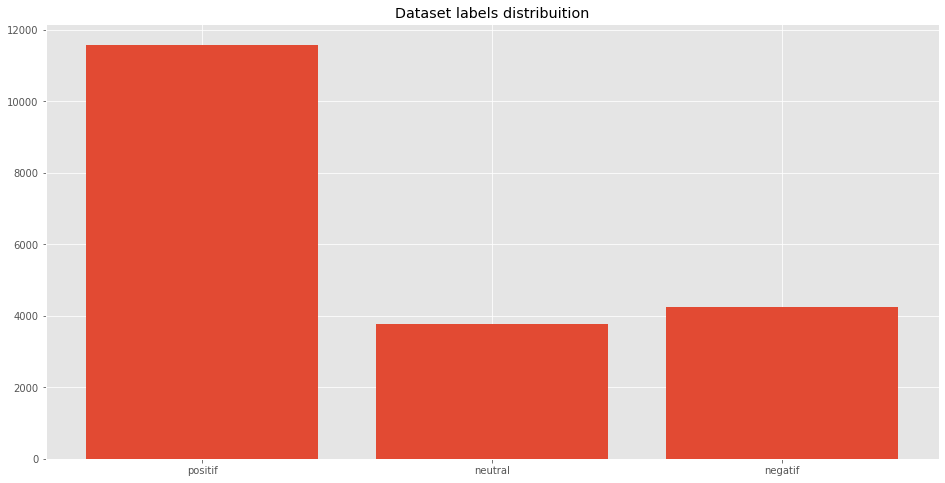

In [472]:
status_cnt = Counter(new_df.status_lexicon)

plt.figure(figsize=(16,8))
plt.bar(status_cnt.keys(), status_cnt.values())
plt.title("Dataset labels distribuition")

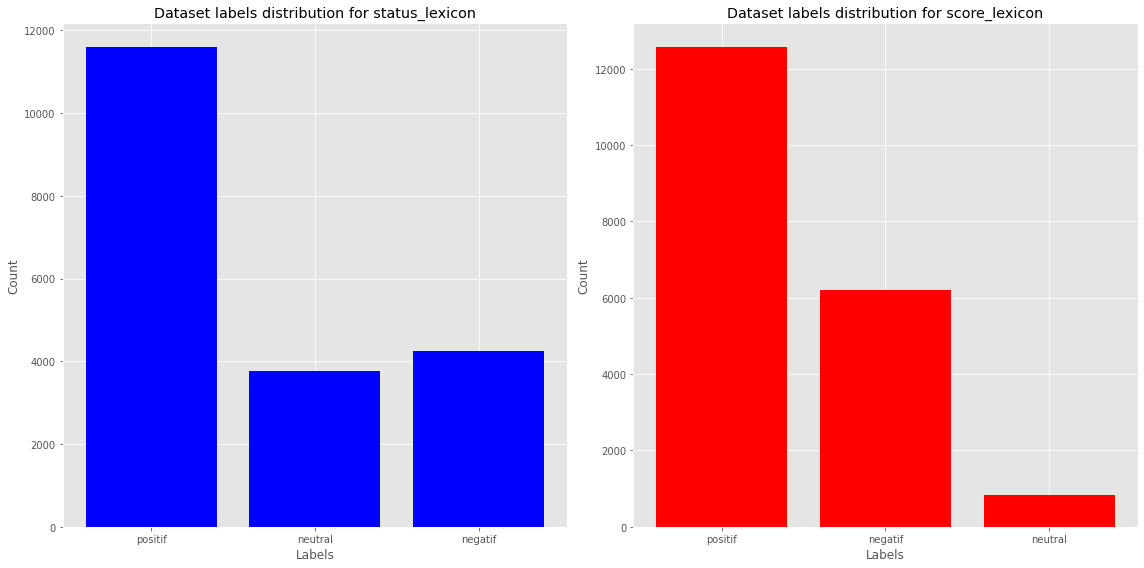

In [473]:
# Menghitung frekuensi dari status_lexicon
status_cnt = Counter(new_df.status_lexicon)

# Menghitung frekuensi dari score_lexicon
score_cnt = Counter(new_df.score_lexicon)

# Membuat figure dengan 2 subplot
fig, ax = plt.subplots(1, 2, figsize=(16,8))

# Visualisasi status_lexicon
ax[0].bar(status_cnt.keys(), status_cnt.values(), color='b')
ax[0].set_title("Dataset labels distribution for status_lexicon")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Labels")

# Visualisasi score_lexicon
ax[1].bar(score_cnt.keys(), score_cnt.values(), color='r')
ax[1].set_title("Dataset labels distribution for score_lexicon")
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Labels")

# Menyesuaikan layout
plt.tight_layout()
plt.show()


In [474]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Membuat subplot dengan 1 baris dan 2 kolom
fig = sp.make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

# Menambahkan pie chart pertama untuk status_lexicon
fig.add_trace(go.Pie(labels=list(status_cnt.keys()), values=list(status_cnt.values()), name="status_lexicon",title="status lexicon"),
              1, 1)

# Menambahkan pie chart kedua untuk score_lexicon
fig.add_trace(go.Pie(labels=list(score_cnt.keys()), values=list(score_cnt.values()), name="score_lexicon",title="score lexicon"),
              1, 2)

# Update layout untuk menampilkan judul dan mengubah warna
fig.update_layout(
    title_text="Dataset labels distribution",
    paper_bgcolor="white",
    plot_bgcolor="black",
    font=dict(color="black")
)

# Menampilkan figure
fig.show()


# Membuat model menggunakan DL Neutral Network

# Word2Vec

In [475]:
#Prepare

#DATASET
TRAIN_SIZE = 0.8

W2V_SIZE = 100
W2V_WINDOW = 10
W2V_EPOCH = 32
W2V_MIN_COUNT = 5

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [476]:
#Split DF
df_train, df_test = train_test_split(new_df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 15688
TEST size: 3923


In [477]:
%%time
documents = [_content.split() for _content in df_train.content]


CPU times: total: 31.2 ms
Wall time: 23 ms


In [478]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [479]:
print(w2v_model)

Word2Vec<vocab=0, vector_size=100, alpha=0.025>


In [480]:
w2v_model.build_vocab(documents)

In [481]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2073


In [482]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: total: 4.62 s
Wall time: 1.65 s


(1980049, 2965024)

In [483]:
w2v_model.wv.most_similar("ok")

[('sipp', 0.8432153463363647),
 ('mantap', 0.8137377500534058),
 ('oke', 0.8085814118385315),
 ('pokoknya', 0.7881645560264587),
 ('mntap', 0.7808826565742493),
 ('ramah2', 0.7725139856338501),
 ('jiwa', 0.7489408850669861),
 ('pokonya', 0.7443935871124268),
 ('joss', 0.7315197587013245),
 ('pokoke', 0.7271432280540466)]

## tokenizer

### Note masih gagal dataset kurang karena tidak seimbang dan ada neutral mungkin nanti akan kita hapus

In [484]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.content)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 12866
CPU times: total: 188 ms
Wall time: 181 ms


In [485]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.content), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.content), maxlen=SEQUENCE_LENGTH)

CPU times: total: 234 ms
Wall time: 227 ms


In [486]:
encoder = LabelEncoder()
encoder.fit(df_train.status_lexicon.tolist())

y_train = encoder.transform(df_train.status_lexicon.tolist())
y_test = encoder.transform(df_test.status_lexicon.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (15688, 1)
y_test (3923, 1)


In [487]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (15688, 300)
y_train (15688, 1)

x_test (3923, 300)
y_test (3923, 1)


In [488]:
y_train[:10]

array([[2],
       [2],
       [1],
       [2],
       [0],
       [2],
       [0],
       [2],
       [0],
       [2]])

In [511]:
df_train[:10]

,userName,score,at,content,[preprocessed_content],lexicon_positif,lexicon_negatif,final_lexicon,status_lexicon,score_lexicon
11660,octa herlangga,1,2023-02-08 13:49:08,terima kasih,"[terima, kasih]",4,-1,3,positif,negatif
11342,Novia Nurdianti,5,2023-02-09 21:19:31,mksh gojek memdahkan skli membantu mnjdi kuali...,"[mksh, gojek, memdahkan, skli, membantu, mnjdi...",11,0,11,positif,positif
9071,rava ditya,1,2023-02-19 18:03:36,uang dikembalikan,"[uang, dikembalikan]",0,0,0,neutral,negatif
17971,Zulian Nur Fauzi,5,2023-01-14 11:40:36,oke,[oke],2,0,2,positif,positif
15790,Fredi Saputro,5,2023-01-22 22:54:48,pengiriman cepat,"[pengiriman, cepat]",3,-8,-5,negatif,positif
8918,Yopy Nouvan Pakasie,5,2023-02-20 13:20:24,good additional value app,"[good, additional, value, app]",5,0,5,positif,positif
10346,Sugiyanto Sukiyo,5,2023-02-14 00:25:25,muantwap bwener nihrugi klau ampe kg gabung sa...,"[muantwap, bwener, nihrugi, klau, ampe, kg, ga...",0,-5,-5,negatif,positif
6253,Hendra 888,5,2023-03-03 13:53:48,sesuai tujuan,"[sesuai, tujuan]",3,0,3,positif,positif
3434,Zulfikar Fauzi,1,2023-03-15 09:36:35,customer gojek terhormat ketahui dibalik mahal...,"[customer, gojek, terhormat, ketahui, dibalik,...",6,-7,-1,negatif,negatif
7414,Mahkotahijab Makassar,5,2023-02-26 18:47:46,membantu bisnis kebutuhan harian sayang go mar...,"[membantu, bisnis, kebutuhan, harian, sayang, ...",18,-9,9,positif,positif


### Embendding

In [489]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(12866, 100)


In [490]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [493]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1286600   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1367101 (5.22 MB)
Trainable params: 80501 (314.46 KB)
Non-trainable params: 1286600 (4.91 MB)
_________________________________________________________________


In [494]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [495]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [496]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
14/14 [==============================] - 133s 10s/step - loss: 0.1792 - accuracy: 0.2155 - val_loss: -1.2847 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 2/8
14/14 [==============================] - 176s 13s/step - loss: -2.9704 - accuracy: 0.1918 - val_loss: -4.0245 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 3/8
14/14 [==============================] - 244s 18s/step - loss: -4.9252 - accuracy: 0.1918 - val_loss: -5.2375 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 4/8
14/14 [==============================] - 282s 20s/step - loss: -5.9425 - accuracy: 0.1918 - val_loss: -5.9613 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 5/8
14/14 [==============================] - 312s 22s/step - loss: -6.6765 - accuracy: 0.1918 - val_loss: -6.6075 - val_accuracy: 0.1995 - lr: 0.0010
Epoch 6/8
14/14 [==============================] - 336s 24s/step - loss: -7.3791 - accuracy: 0.1918 - val_loss: -7.2836 - val_accuracy: 0.1995 - lr: 0.0010
CPU times: total: 1h 3min 26s
Wall time: 24min 43s


In [497]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

4/4 [==============================] - 8s 2s/step - loss: -7.8854 - accuracy: 0.1894

ACCURACY: 0.18939587473869324
LOSS: -7.885361671447754
CPU times: total: 25.5 s
Wall time: 7.95 s


In [515]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[1]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[0]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [516]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [524]:
predict("sangat suka banget apalagi drivernya baik")

1/1 [==============================] - 0s 50ms/step


{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.10370159149169922}

In [518]:
predict("ok")

1/1 [==============================] - 0s 49ms/step


{'label': 'POSITIVE', 'score': 1.0, 'elapsed_time': 0.09075474739074707}